In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from numba import jit

ModuleNotFoundError: No module named 'numba'

## MAIN TASK

In this coursework assignment, you are meant to value derivatives using binomial trees, Monte-Carlo
simulations, the finite difference method, and the Longstaff-Schwartz least-squares approach. To this
end, assume the following set of baseline parameters: The initial stock price (S0) is 35, the stock volatility is 0.45 (45% per annum), and the risk-free rate is 0.03 (3% per annum). Consider a European put
option whose strike price is equal to 35, with a time-to-maturity of one year. The dividend yield is 0.04
(4% per annum). In some later tasks, you also encounter the “equivalent” American option.

### Task 1

Use the Black-Scholes (1973) formula to calculate the value of the option. Use put-call parity to calculate the value of the “equivalent” call option (same underlying, strike price, and maturity date).

**Black-Scholes formula:**
$$P = K e^{-rT} N(-d_2) - S_0 N(-d_1)$$

where:
- $d_1$ and $d_2$ are defined as:
  $$
  d_1 = \frac{\ln(S_0 / K) + (r + \sigma^2 / 2) T}{\sigma \sqrt{T}}
  $$
  $$
  d_2 = d_1 - \sigma \sqrt{T}
  $$

As there is dividend yield of 4% per annum, we should adjust our initial price on a certain value. So the final Black-Scholes formula will look like:

$$P = K e^{-rT} N(-d_2) - S_0 e^{-qT} N(-d_1)$$

where:
- $d_1$ and $d_2$ are defined as:
  $$
  d_1 = \frac{\ln(S_0 / K) + (r - q + \sigma^2 / 2) T}{\sigma \sqrt{T}}
  $$
  $$
  d_2 = d_1 - \sigma \sqrt{T}
  $$

In [3]:
# Parameters
S0 = 35          # Initial stock price
K = 35           # Strike price in GBP
T = 1            # Time to maturity in years (1 year)
r = 0.03         # Risk-free interest rate (3% per annum)
sigma = 0.45     # Volatility of the stock's returns
q = 0.04         # Dividend yield (4% per annum)

# d1 and d2 calculations
d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)

# Put option price calculation
put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * np.exp(-q * T) * norm.cdf(-d1)

print(f"Price of the put option using Black-Scholes formula is {round(put_price, 3)}")

Price of the put option using Black-Scholes formula is 6.187


Put-call parity is defined by the following formula [Hull, page 242, formula (11.6)]:

$$c + K e^{-rT} = p + S_0$$

where:
- $c$ and $K e^{-rT}$ are the components of first asset

  and 
  
  $p$ and $S_0$ are the components of second asset

Let's derive value of the call option from the formula above

$$c = p + S_0 - K e^{-rT}$$

Also, we should not forget about the dividends. That is why we should adjust initial value price:

$$c = p + S_0 e^{-qT} - K e^{-rT}$$

In [4]:
call_price = put_price + S0 * np.exp(-q * T) - K * np.exp(-r * T)
print(f"Price of the call option using put-call parity formula is {round(call_price, 5)}")

Price of the call option using put-call parity formula is 5.84898


### Task 2

Use a simple one-step binomial tree to value the above European put option. Set u equal to the exponential of sigma times the square root of the maturity time divided by the number of time steps (i.e., $e^{σ * (T/n)^{1/2}}$) and $d$ equal to the exponential of minus one times sigma times the square root of the maturity time divided by the number of time steps (i.e., $e^{-σ * (T/n)^{1/2}}$).

After that, increase the number of time steps (n) and repeat the binomial tree value calculation. So, for example, use a binomial tree with two, then three, then four, then five, then six, etc. time steps to value the option. I’ll leave it up to you how many binomial trees you use in your calculations. I would expect that the average group does binomial trees with one-, two-, three-, four-, and five-time steps. But the sky is the limit, and the more binomial trees you calculate the better for your mark.

Don’t show each and every binomial tree you do in the coursework assignment. Showing one tree is certainly enough for illustrative purposes. Keep the page limit in mind!

Plot the value of the European put option (y-axis) against the number of time steps used in the binomial tree (x-axis). Also plot the Black-Scholes value (e.g., as horizontal line) in the graph. Do more time steps render the binomial tree value closer to the Black-Scholes (1973) value? Explain in intuitive language why this is the case (you would want to look at your textbook)

In [25]:
# Parameters
S0 = 35
K = 35
r = 0.03
sigma = 0.45
T = 1
q = 0.04

N = 1000
dt = T / N

# Initialize asset price array
asset_price = np.zeros((N+1, N+1))

u = np.exp(sigma * np.sqrt(dt))
d = 1 / u

# Populate asset price array
for i in range(N+1):
    for j in range(i+1):
        asset_price[j, i] = S0 * (u**(i-j)) * (d**j)

# Probability and payoff initialization
p = (np.exp((r - q) * dt) - d) / (u - d)
payoff = np.zeros((N+1, N+1))

# Backward induction for option payoff
for i in range(N, -1, -1):
    for j in range(i+1):
        if i == N:  # At maturity
            payoff[j, i] = np.maximum((K - asset_price[j, i]), 0)
        else:  # Discounted expected payoff
            payoff[j, i] = ((p * payoff[j, i+1]) + ((1-p) * payoff[j+1, i+1])) * np.exp(-r * dt)

print(f"Option price is {round(payoff[0, 0], 3)}")

Option price is 6.185


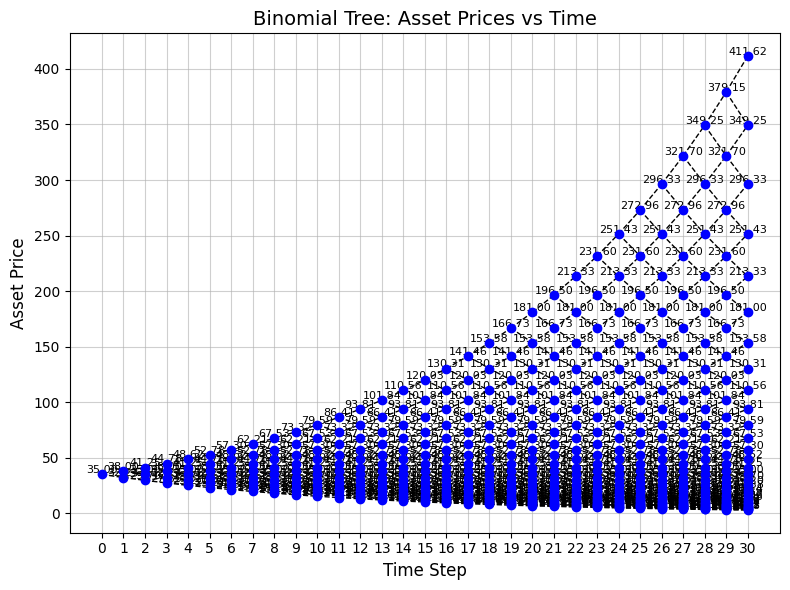

In [12]:
# Plot the binomial tree with asset prices on the y-axis
fig, ax = plt.subplots(figsize=(8, 6))

# Loop through the array to extract and plot the binomial tree
for i in range(N+1):
    for j in range(i+1):
        # Plot each node
        ax.scatter(i, asset_price[j, i], color="blue", zorder=5)  # Time step (x-axis), asset price (y-axis)
        # Annotate with asset price
        ax.text(i, asset_price[j, i] + 1, f"{asset_price[j, i]:.2f}", ha="center", fontsize=8)

        # Draw lines to child nodes if not at the last column
        if i < N:
            # Line to "up" node
            ax.plot([i, i+1], [asset_price[j, i], asset_price[j, i+1]], color="black", linestyle="--", linewidth=1)
            # Line to "down" node
            ax.plot([i, i+1], [asset_price[j, i], asset_price[j+1, i+1]], color="black", linestyle="--", linewidth=1)

# Customize the plot
ax.set_title("Binomial Tree: Asset Prices vs Time", fontsize=14)
ax.set_xlabel("Time Step", fontsize=12)
ax.set_ylabel("Asset Price", fontsize=12)
ax.set_xticks(range(N+1))
ax.grid(True, linestyle="-", alpha=0.6)
plt.tight_layout()

### Precision of binomial trees

In [7]:
steps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 25, 50, 100, 250, 500, 1000]
price_list = []

for step in steps:
    # Parameters
    S0 = 35
    K = 35
    r = 0.03
    sigma = 0.45
    T = 1
    q = 0.04

    N = step
    dt = T / N

    # Initialize asset price array
    asset_price = np.zeros((N+1, N+1))

    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u

    # Populate asset price array
    for i in range(N+1):
        for j in range(i+1):
            asset_price[j, i] = S0 * (u**(i-j)) * (d**j)

    # Probability and payoff initialization
    p = (np.exp((r - q) * dt) - d) / (u - d)
    payoff = np.zeros((N+1, N+1))

    # Backward induction for option payoff
    for i in range(N, -1, -1):
        for j in range(i+1):
            if i == N:  # At maturity
                payoff[j, i] = np.maximum((K - asset_price[j, i]), 0)
            else:  # Discounted expected payoff
                payoff[j, i] = ((p * payoff[j, i+1]) + ((1-p) * payoff[j+1, i+1])) * np.exp(-r * dt)

    price_list.append(round(payoff[0, 0], 3))

print(price_list)

[np.float64(7.647), np.float64(5.502), np.float64(6.682), np.float64(5.826), np.float64(6.483), np.float64(5.942), np.float64(6.397), np.float64(6.002), np.float64(6.35), np.float64(6.039), np.float64(6.245), np.float64(6.157), np.float64(6.172), np.float64(6.181), np.float64(6.184), np.float64(6.185)]


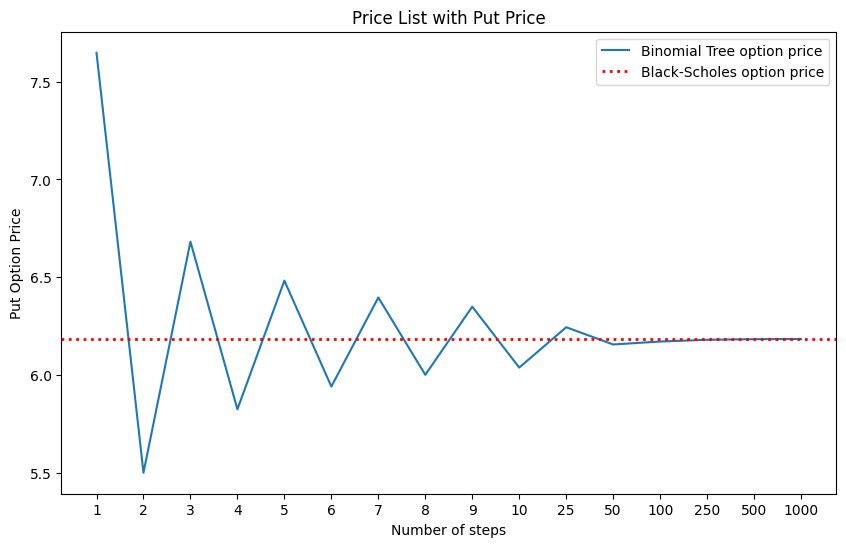

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(price_list)), price_list, label='Binomial Tree option price')
plt.axhline(y=put_price, color='red', linestyle=':', linewidth=2, label='Black-Scholes option price')
plt.xlabel('Number of steps')
plt.xticks(ticks=range(len(steps)), labels=steps)
plt.ylabel('Put Option Price')
plt.title('Price List with Put Price')
plt.legend()

### Task 3

#### More Complicated Binomial Tree

Now assume that you want to value an American floating look-back put option, whose maturity payoff is the difference between the maximum stock price to that date and the current stock price (see the slides 17 and 18 in the lecture on “More on Models and Numerical Procedures”). To do so, again use a binomial tree approach. As using a binomial tree approach to value American floating look-back calls quickly becomes rather complicated, I am okay with you relying on a smaller binomial tree than in the prior task. That said, I want you to use at least a three-step tree, and, as always, the larger your binomial tree, the better for your mark (assuming you do the calculations correctly).

##### Approach used to calculate the value

A floating lookback call is a way that the holder can buy the underlying asset at the lowest price achieved during the life of the option. Similarly, a floating lookback put is a way that the holder can sell the underlying asset at the highest price achieved during the life of the option

1. determine the stock value at each node (as before);
2. determine the possible stock value maxima at each node;
3. value the option for each possible maximum at each node, moving
backward from maturity to contract initiation;

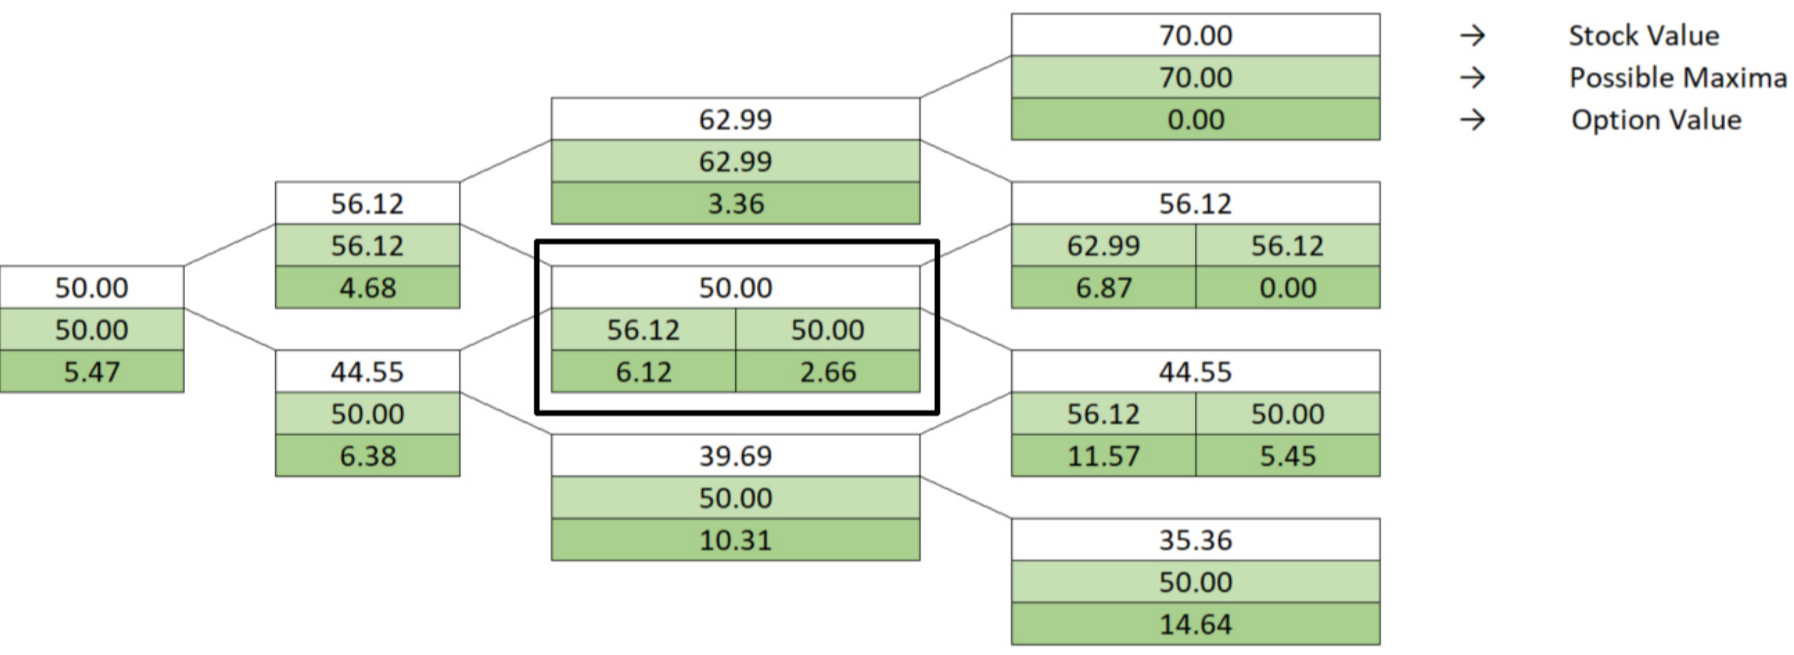

In [33]:
@jit(nopython=True)
def american_floating_lookback_call_binomial(S0, r, q, sigma, T, N):

    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1/u
    # Risk-neutral probability
    p = (np.exp((r - q)*dt) - d) / (u - d)

    discount = np.exp(-r * dt)

    # Build the binomial tree for the underlying asset prices
    S = np.zeros((N+1, N+1))
    for i in range(N+1):
        for j in range(i+1):
            S[j, i] = S0 * (u**(i-j)) * (d**j)

    # At each time step i, we consider the set of possible maximum prices.
    # An important observation is that the maximum price at time step i must be one of the prices {S[k,l] for l<=i, 0<=k<=l}.
    # We will construct a list of unique prices up to time step i and use that as the set of possible maximum prices at time step i.

    # Precompute the sets of possible maxima at each time step:
    possible_maxima_per_time = []
    for i in range(N+1):
        # Collect all prices from time 0 to i
        prices_up_to_i = []
        for t_step in range(i+1):
            for node in range(t_step+1):
                prices_up_to_i.append(S[node, t_step])
        # Get unique and sort them
        unique_prices = np.unique(np.array(prices_up_to_i))
        possible_maxima_per_time.append(unique_prices)

    # Create data structures to hold probabilities and values.
    # Store a 3D array: values[i, j, m], probabilities[i, j, m]
    # Where m indexes into possible_maxima_per_time[i].
    # Initially, at i=0: only one node (0,0) and max = S0
    values = [[np.zeros(len(possible_maxima_per_time[i])) for j in range(i+1)] for i in range(N+1)]
    probs = [[np.zeros(len(possible_maxima_per_time[i])) for j in range(i+1)] for i in range(N+1)]

    # Initialize at time 0:
    initial_max_list = possible_maxima_per_time[0]
    # Find index of S0 in this list
    m_idx = np.where(initial_max_list == S0)[0][0]
    probs[0][0][m_idx] = 1.0  # 100% probability of starting with max=S0
    values[0][0][m_idx] = 0.0 # No immediate payoff

    # Forward induction of probabilities (no payoffs)
    for i in range(N):
        for j in range(i+1):
            current_max_list = possible_maxima_per_time[i]
            up_max_list = possible_maxima_per_time[i+1]
            down_max_list = possible_maxima_per_time[i+1]

            for m_idx, prob_m in enumerate(probs[i][j]):
                if prob_m <= 1e-14:
                    continue
                current_val = values[i][j][m_idx]
                current_max = current_max_list[m_idx]
                Sij = S[j,i]

                # Up child
                up_node_price = S[j, i+1]
                new_up_max = np.maximum(current_max, up_node_price)
                # Find index of new_up_max in up_max_list
                up_m_idx = np.where(up_max_list == new_up_max)[0][0]
                probs[i+1][j][up_m_idx] += prob_m * p

                # Down child
                down_node_price = S[j+1, i+1]
                new_down_max = np.maximum(current_max, down_node_price)
                down_m_idx = np.where(down_max_list == new_down_max)[0][0]
                probs[i+1][j+1][down_m_idx] += prob_m * (1-p)

    # At maturity, compute payoff = max(M - S_T, 0)
    for j in range(N+1):
        final_max_list = possible_maxima_per_time[N]
        for m_idx, pm in enumerate(probs[N][j]):
            if pm > 1e-14:
                Mfinal = final_max_list[m_idx]
                payoff = np.maximum(Mfinal - S[j,N], 0)
                values[N][j][m_idx] = payoff

    # Backward induction of values
    # At each step i, for each state (j, m_idx), compute continuation from children and compare with immediate exercise.
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            current_max_list = possible_maxima_per_time[i]
            up_max_list = possible_maxima_per_time[i+1]
            down_max_list = possible_maxima_per_time[i+1]

            new_values = np.zeros(len(current_max_list))
            # Probability array for normalization
            current_probs = probs[i][j]

            for m_idx, pm in enumerate(current_probs):
                if pm <= 1e-14:
                    continue

                current_max = current_max_list[m_idx]
                Sij = S[j,i]
                immediate_ex = np.maximum(current_max - Sij, 0)

                # Find children's states for continuation
                up_node_price = S[j, i+1]
                down_node_price = S[j+1, i+1]

                # Up child max state
                new_up_max = np.maximum(current_max, up_node_price)
                up_m_idx = np.where(up_max_list == new_up_max)[0][0]

                # Down child max state
                new_down_max = np.maximum(current_max, down_node_price)
                down_m_idx = np.where(down_max_list == new_down_max)[0][0]

                val_up = values[i+1][j][up_m_idx]
                val_down = values[i+1][j+1][down_m_idx]

                continuation_value = discount * (p * val_up + (1-p)* val_down)

                # American feature:
                node_value = np.maximum(immediate_ex, continuation_value)
                new_values[m_idx] = node_value

            # Update values at this node:
            values[i][j] = new_values

    # The initial node (0,0) with initial max = S0:
    # Find index of S0 in possible_maxima_per_time[0]
    initial_m_idx = np.where(possible_maxima_per_time[0] == S0)[0][0]
    option_price = values[0][0][initial_m_idx]
    return option_price, S, values, possible_maxima_per_time

S0 = 35
r = 0.03
q = 0.04
sigma = 0.45
T = 1
N = 250

price, S, values, possible_maxima_per_time = american_floating_lookback_call_binomial(S0, r, q, sigma, T, N)
print("Estimated American Floating Lookback Call Price:", round(price, 3))

Estimated American Floating Lookback Call Price: 13.498


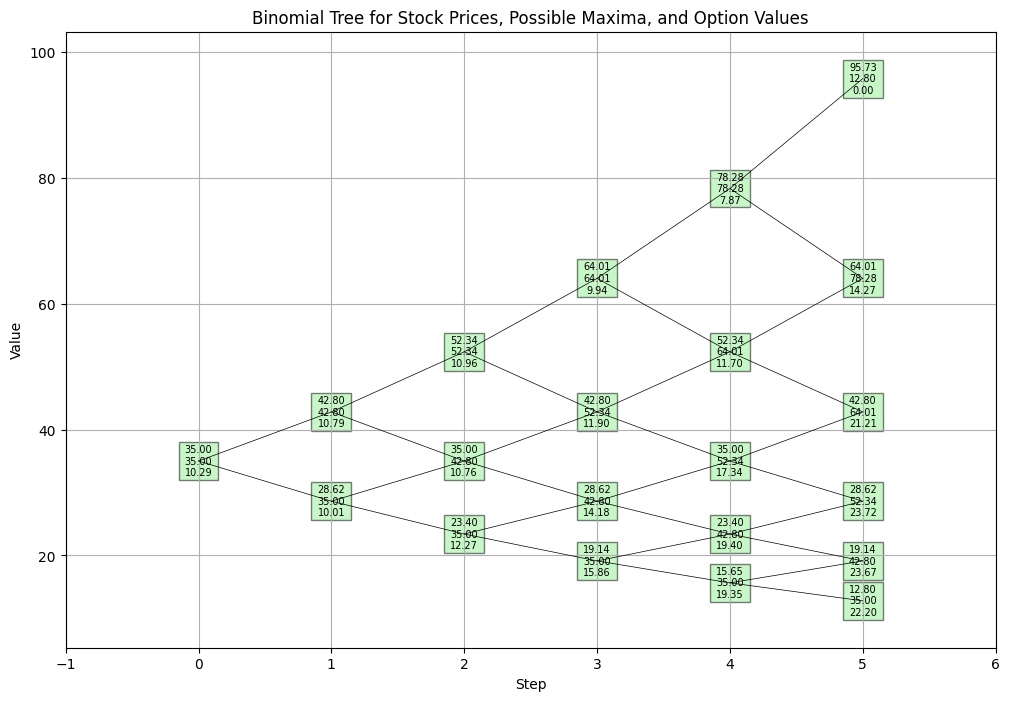

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Binomial Tree for Stock Prices, Possible Maxima, and Option Values")
ax.set_xlabel("Step")
ax.set_ylabel("Value")

# Plotting the tree with connections and square labels
for i in range(N+1):
    for j in range(i+1):
        # Draw connections between nodes
        if i < N:
            ax.plot([i, i + 1], [S[j, i], S[j, i + 1]], color='black', linestyle='-', linewidth=0.5)
            ax.plot([i, i + 1], [S[j, i], S[j + 1, i + 1]], color='black', linestyle='-', linewidth=0.5)

        # Find a meaningful state to display
        max_prices = possible_maxima_per_time[i]
        node_values = values[i][j]
        
        # If there are multiple states, pick the one with the highest option value
        if len(node_values) > 0:
            m_idx = np.argmax(node_values)
            current_max = max_prices[m_idx]
            node_value = node_values[m_idx]
        else:
            # If no states, default to something reasonable
            current_max = S[j,i]
            node_value = 0.0

        # Draw a rectangle behind the text
        rect = patches.Rectangle(
            (i - 0.15, S[j, i] - 3.0), 0.3, 6,
            linewidth=1, edgecolor='black', facecolor='lightgreen', alpha=0.5,
        )
        ax.add_patch(rect)

        # Annotate with stock price, chosen max price, and chosen node value
        ax.text(i, S[j, i], f"{S[j, i]:.2f}\n{current_max:.2f}\n{node_value:.2f}", ha='center', va='center', fontsize=7, color='black')

ax.set_xlim(-1, N+1)
ax.grid(True)

## Task 4a 

Use Monte Carlo simulation to value the European put option assuming that the underlying asset value obeys a Geometric Brownian motion. To do so, you can directly simulate the value of the stock at maturity (as we did in the lecture) – you don’t need to simulate the whole path. I leave it up to you how many maturity stock prices you generate. The more, the better (as always).

In [ ]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt


# Initial Values
s0 = 30
k = 26
t = 1.0 # in years
r = 0.04 # used for mu in calculations
sigma = 0.3 
ns = [252] # time steps
runs = 1000000 # number of runs
total = 0
disc = np.exp(-r*t) # discount rate


########################################################################################################################
########################################################################################################################
########################################################################################################################
# Plot Paths using discrete time method - NO ADDITIONS
def discrete_plot():
    for plots in range(len(ns)):
        n = ns[plots]
        dt = t / n # time steps
        #disc = 1-(r * dt) # Discount rate (discrete, calculated at each time step)
    
        # Create an array of lists
        st = np.zeros((runs, n + 1))
        
        # Initialise first value in each list as s0
        st[:, 0] = s0
        
        # Create an array z of lists with random standard normal values
        z = np.random.standard_normal((runs, n))
        
        # Individual runs
        for step in range(1, n + 1):
        
            # Calcuate each step (non-discounted)
            st[:, step] = st[:, step - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * z[:, step - 1] * np.sqrt(dt))
        
            # Discount each step (discrete rate)
            #st[:, step] *= disc
        
        # Array of steps
        steps = np.linspace(0, t, n + 1)
        
        # Plot each run
        for i in range(n):
            plt.plot(steps, st[i, :])
        
        # Calculate mean payoff
        final_values = np.maximum(st[:, -1]-k, 0)
        mean = np.mean(final_values)
        print(mean)
        print(mean*disc)
        
        # Graph stuff
        plt.grid(True, which = 'major', linestyle = '-')
        plt.grid(True, which = 'minor', linestyle = '--')
        plt.ylabel("Stock Price ($\$$)")
        plt.xlabel("Time (Years)")
        plt.title(f'Time Period: {t}yrs, Runs: {runs}, Time Steps: {n}, Average Payout: {mean*disc:.6}')
        plt.savefig(f'MonteCarlo_r_{runs}_n_{n}.png', bbox_inches='tight', dpi = 1200)
        plt.show()


# Plot using discrete time
# discrete_plot()

########################################################################################################################
########################################################################################################################
########################################################################################################################
# Direct solve method - NO ADDITIONS
def direct_solve(runs):

    # list of payoffs
    payoffs = []

    # Individual runs
    for run in range(1, runs+1):

        # Generate random z
        z = np.random.standard_normal()

        # Calculate St
        st = s0 * np.exp((r - 0.5 * sigma ** 2) * t + sigma * z * np.sqrt(t))

        # Find payoff 
        payoff = np.maximum(st-k, 0)

        # Append payoff
        payoffs.append(payoff)

    # Calculate mean
    mean = np.mean(payoffs)

    # Discount mean
    discounted_mean = mean * disc

    # print discounted_mean
    print(f'Discounted Mean for {runs} runs = {discounted_mean}')

# Calculate using direct method and #runs - NO ADDITIONS
direct_solve(100000)


########################################################################################################################
########################################################################################################################
########################################################################################################################

# Direct solve method - WITH ADDITIONS: 

def direct_solve_2(runs):
    return 0
    
# Calculate using direct method and #runs - NO ADDITIONS
# direct_solve_2(100000)

Discounted Mean for 100000 runs = 6.405096007920654


Discounted Mean Payoff for direct solution using 10000 runs = 6.680523289906577
6.126417803410692
Discounted mean payoff using stochastic interest and 100 runs = 5.945340274031075, over 1.0 years


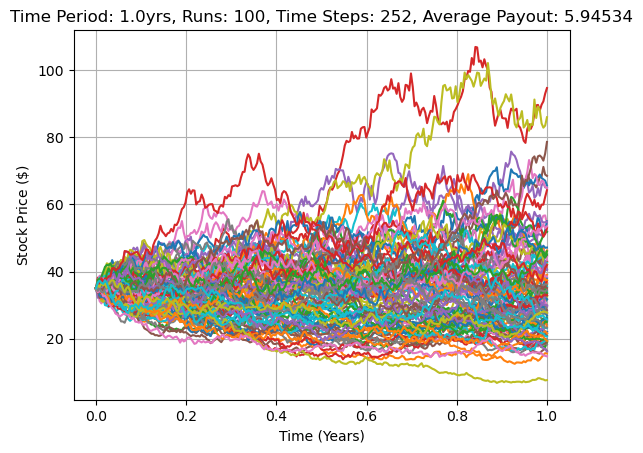

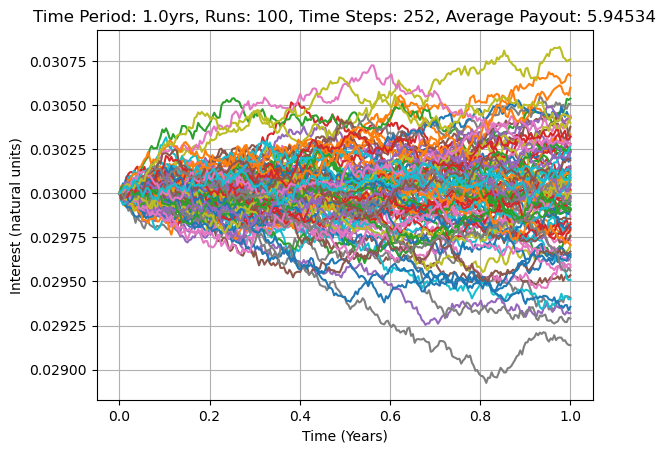

6.1264285631634
Discounted mean payoff using stochastic interest and 100 runs = 5.945347809570141, over 1.0 years


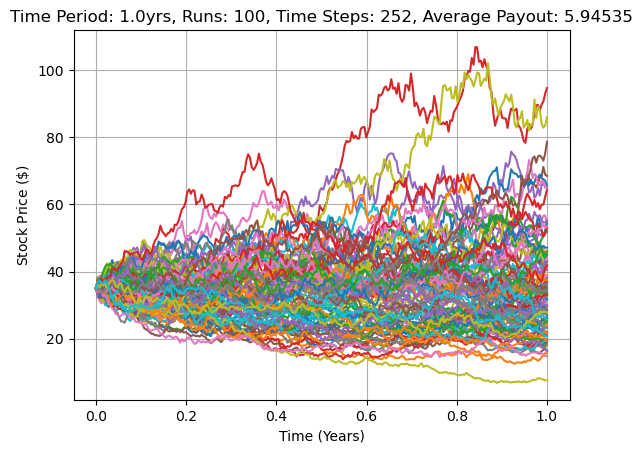

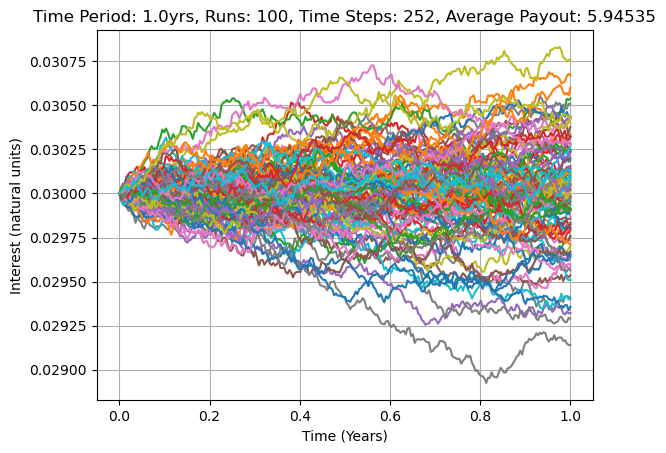

In [7]:

##########################
# task 4a



# Initial Values
s0 = 35
k = 35
t = 1.0 # in years
r0 = 0.03 # used for mu in calculations
q = 0.04
sigma_s = 0.45
ns = [252] # time steps
runs = 100 # number of runs
disc = np.exp(-r0*t) # discount rate

rho = -0.15 ## ASSUMED
np.random.seed(42)

def direct_solve(runs):

    # list of payoffs
    payoffs = []

    # Individual runs
    for run in range(1, runs+1):

        # Generate random z
        z = np.random.standard_normal()

        # Calculate St
        st = s0 * np.exp((r0 - 0.5 * sigma_s ** 2) * t + sigma_s * z * np.sqrt(t))

        # Find payoff 
        payoff = np.maximum(st-k, 0)

        # Append payoff
        payoffs.append(payoff)

    # Calculate mean
    mean = np.mean(payoffs)

    # Discount mean
    discounted_mean = mean * disc

    # print discounted_mean
    print(f'Discounted Mean Payoff for direct solution using {runs} runs = {discounted_mean}')

# Calculate using direct method and #runs - NO ADDITIONS
direct_solve(10000)



########################################
# 4b WITH and WIHTOUT mean regression

# Import Libraries
import numpy as np
import matplotlib.pyplot as plt


# Initial Values
s0 = 35
k = 35
t = 1.0 # in years
r0 = 0.03 # used for mu in calculations
q = 0.04
sigma_s = 0.45
ns = [252] # time steps
runs = 100 # number of runs
disc = np.exp(-r0*t) # discount rate

rho = -0.15 ## ASSUMED
np.random.seed(42)

# Other values
pos_mu_r = 0.001
# mu_r = pos_mu_r
neg_mu_r = - 0.001
sigma_r = 0.01

########################################################################################################################
########################################################################################################################
########################################################################################################################
# Plot Paths using discrete time method - NO ADDITIONS
def discrete_plot():
    # global mu_r
    for plots in range(len(ns)):
        n = ns[plots]
        dt = t / n # time steps
        #disc = 1-(r * dt) # Discount rate (discrete, calculated at each time step)
    
        # Create an array of lists
        st = np.zeros((runs, n + 1)) # [[first run],[second run],[]]

        # Create an array of lists
        rs = np.zeros((runs, n + 1)) # [[],[],[]]
        
        # Initialise first value in each list as s0
        st[:, 0] = s0

        # Initialise first value in each list as r0
        rs[:, 0] = r0
        
        # Create an array z of lists with random standard normal values
        z1 = np.random.standard_normal((runs, n)) #s [[zs for first run],[zs for second run],[]]
        z2 = (rho * z1) + (np.random.standard_normal((runs, n))*np.sqrt(1-(rho**2))) # r [[],[],[]]

        interest_averages = []
        
        mu_r = pos_mu_r
        mu_r_lst = [mu_r] * (n + 1)  # Initialize list of mu_r values for each step
        
        for step in range(1, n + 1): # looping through time steps in a single run # all of the runs at the same time
            # Calcuate each step (non-discounted)

            
            rs[:, step] = rs[:, step - 1] * np.exp((mu_r_lst[step] - 0.5 * sigma_r ** 2) * dt + sigma_r * z2[:, step - 1] * np.sqrt(dt))

            # Update mu_r for each run based on change in interest rate
            
            if step != n:
                for run_iteration in range(runs):  # Corrected range to avoid IndexError
                    if rs[run_iteration, step] > rs[run_iteration, step - 1]:
                        mu_r_lst[step+1] = neg_mu_r
                    else:
                        mu_r_lst[step+1] = pos_mu_r
                
            st[:, step] = st[:, step - 1] * np.exp((rs[:, step][-1] - 0.5 * sigma_s ** 2) * dt + sigma_s * z1[:, step - 1] * np.sqrt(dt))
            interest_averages.append(rs)
        
        # For each 
        interest_averages = []

        for run_int in rs:
            interest_averages.append(np.mean(run_int))

        # Array of steps
        steps = np.linspace(0, t, n + 1)
        
        # Plot each run
        for i in range(runs):
            plt.plot(steps, st[i, :])
        
        # Calculate mean payoff
        final_values = np.maximum(st[:, -1]-k, 0) # of s
        mean_payoff = np.mean(final_values) # of s
        print(mean_payoff) 
        
        mean_interest = np.mean(interest_averages)
        disc = np.exp(-mean_interest*t)
        print(f'Discounted mean payoff using stochastic interest and {runs} runs = {mean_payoff*disc}, over {t} years')
        
        # Graph stuff
        plt.grid(True, which = 'major', linestyle = '-')
        plt.grid(True, which = 'minor', linestyle = '--')
        plt.ylabel("Stock Price ($\$$)")
        plt.xlabel("Time (Years)")
        plt.title(f'Time Period: {t}yrs, Runs: {runs}, Time Steps: {n}, Average Payout: {mean_payoff*disc:.6}')
        plt.savefig(f'MonteCarlo_r_{runs}_n_{n}.png', bbox_inches='tight', dpi = 1200)
        plt.show()

        # Plot each run
        for i in range(runs):
            plt.plot(steps, rs[i, :])

        # Graph stuff
        plt.grid(True, which = 'major', linestyle = '-')
        plt.grid(True, which = 'minor', linestyle = '--')
        plt.ylabel("Interest (natural units)")
        plt.xlabel("Time (Years)")
        plt.title(f'Time Period: {t}yrs, Runs: {runs}, Time Steps: {n}, Average Payout: {mean_payoff*disc:.6}')
        plt.savefig(f'MonteCarlo_r_{runs}_n_{n}.png', bbox_inches='tight', dpi = 1200)
        plt.show()

# Plot using discrete time
discrete_plot()




# Initial Values
s0 = 35
k = 35
t = 1.0 # in years
r0 = 0.03 # used for mu in calculations
q = 0.04
sigma_s = 0.45
ns = [252] # time steps
runs = 100 # number of runs
disc = np.exp(-r0*t) # discount rate

rho = -0.15 ## ASSUMED
np.random.seed(42)

# Other values
pos_mu_r = 0.00001
# mu_r = pos_mu_r
neg_mu_r = - 0.00001
sigma_r = 0.01


# Plot Paths using discrete time method - NO ADDITIONS
def discrete_plot():
    # global mu_r
    for plots in range(len(ns)):
        n = ns[plots]
        dt = t / n # time steps
        #disc = 1-(r * dt) # Discount rate (discrete, calculated at each time step)
    
        # Create an array of lists
        st = np.zeros((runs, n + 1)) # [[first run],[second run],[]]

        # Create an array of lists
        rs = np.zeros((runs, n + 1)) # [[],[],[]]
        
        # Initialise first value in each list as s0
        st[:, 0] = s0

        # Initialise first value in each list as r0
        rs[:, 0] = r0
        
        # Create an array z of lists with random standard normal values
        z1 = np.random.standard_normal((runs, n)) #s [[zs for first run],[zs for second run],[]]
        z2 = (rho * z1) + (np.random.standard_normal((runs, n))*np.sqrt(1-(rho**2))) # r [[],[],[]]

        interest_averages = []
        
        mu_r = pos_mu_r
        mu_r_lst = [mu_r] * (n + 1)  # Initialize list of mu_r values for each step
        
        for step in range(1, n + 1): # looping through time steps in a single run # all of the runs at the same time
            # Calcuate each step (non-discounted)

            
            rs[:, step] = rs[:, step - 1] * np.exp((mu_r_lst[step] - 0.5 * sigma_r ** 2) * dt + sigma_r * z2[:, step - 1] * np.sqrt(dt))

            # Update mu_r for each run based on change in interest rate
            
            #if step != n:
            #    for run_iteration in range(runs):  # Corrected range to avoid IndexError
            #        if rs[run_iteration, step] > rs[run_iteration, step - 1]:
            #            mu_r_lst[step+1] = neg_mu_r
            #        else:
            #            mu_r_lst[step+1] = pos_mu_r
                
            st[:, step] = st[:, step - 1] * np.exp((rs[:, step][-1] - 0.5 * sigma_s ** 2) * dt + sigma_s * z1[:, step - 1] * np.sqrt(dt))
            interest_averages.append(rs)
        
        # For each 
        interest_averages = []

        for run_int in rs:
            interest_averages.append(np.mean(run_int))

        # Array of steps
        steps = np.linspace(0, t, n + 1)
        
        # Plot each run
        for i in range(runs):
            plt.plot(steps, st[i, :])
        
        # Calculate mean payoff
        final_values = np.maximum(st[:, -1]-k, 0) # of s
        mean_payoff = np.mean(final_values) # of s
        print(mean_payoff) 
        
        mean_interest = np.mean(interest_averages)
        disc = np.exp(-mean_interest*t)
        print(f'Discounted mean payoff using stochastic interest and {runs} runs = {mean_payoff*disc}, over {t} years')
        
        # Graph stuff
        plt.grid(True, which = 'major', linestyle = '-')
        plt.grid(True, which = 'minor', linestyle = '--')
        plt.ylabel("Stock Price ($\$$)")
        plt.xlabel("Time (Years)")
        plt.title(f'Time Period: {t}yrs, Runs: {runs}, Time Steps: {n}, Average Payout: {mean_payoff*disc:.6}')
        plt.savefig(f'MonteCarlo_r_{runs}_n_{n}.png', bbox_inches='tight', dpi = 1200)
        plt.show()

        # Plot each run
        for i in range(runs):
            plt.plot(steps, rs[i, :])

        # Graph stuff
        plt.grid(True, which = 'major', linestyle = '-')
        plt.grid(True, which = 'minor', linestyle = '--')
        plt.ylabel("Interest (natural units)")
        plt.xlabel("Time (Years)")
        plt.title(f'Time Period: {t}yrs, Runs: {runs}, Time Steps: {n}, Average Payout: {mean_payoff*disc:.6}')
        plt.savefig(f'MonteCarlo_r_{runs}_n_{n}.png', bbox_inches='tight', dpi = 1200)
        plt.show()

# Plot using discrete time
discrete_plot()

## Task 6

Use the finite difference method to value the (plain-vanilla) American put option. I leave it up to you to decide whether you want to use the implicit or explicit method. Motivated groups may consider using both and comparing outcomes. I also leave it up to you how many stock price- and time-steps you use in your grid (but go for more than used in the lecture). I would, however, advise you to simulate the stock price, not the log of the stock price – that’s more intuitive and thus a lot easier. 

### Implicit method

The American put option price at S0 = 35 is approximately: 6.4093


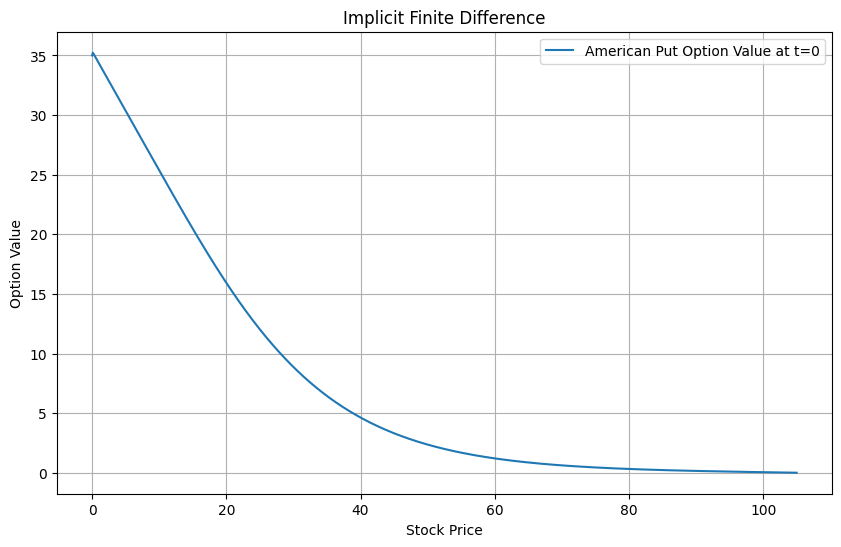

In [3]:
# Parameters
S0 = 35
K = 35
T = 1
r = 0.03
q = 0.04
sigma = 0.45

S_max = 3 * S0  # Stock price upper bound
M = 1000         # Number of stock price steps
N = 1000         # Number of time steps


# Discretisation
dS = S_max / M  # Stock price increment
dt = T / N      # Time increment


# Grid initialisation
stock_prices = np.linspace(0, S_max, M + 1)
option_values = np.zeros((M + 1, N + 1))        # 2D array for option values


# Boundary conditions at maturity
# American put payoff at maturity = max(K - S, 0)
option_values[:, -1] = np.maximum(K - stock_prices, 0)


# Coefficient initialisation
j = np.arange(1, M)     # Index for internal nodes


# Coefficients for implicit method
alpha = 0.5 * dt * ((r - q) * j - (sigma**2) * j**2)
beta = 1 + dt * (sigma**2 * j**2 + (r - q)) 
gamma = -0.5 * dt * ((r - q) * j + (sigma**2) * j**2)


# Prepare vectors for the tridiagonal matrix
a = np.zeros(M - 1)     # Lower diagonal (alpha)
b = np.zeros(M - 1)     # Main diagonal (beta)
c = np.zeros(M - 1)     # Upper diagonal (gamma)
d = np.zeros(M - 1)     # Right-hand side vector (option_values)


# Backward induction using the implicit method
for n in range(N-1, -1, -1):

    # Fill the coefficients a, b, c, & d
    for i in range(1, M):
        a[i - 1] = alpha[i - 1]
        b[i - 1] = beta[i - 1]
        c[i - 1] = gamma[i - 1]
        d[i - 1] = option_values[i, n + 1]

    # Adjust the boundary conditions at each time step
    d[0] -= a[0] * K        # Adjust for lower boundary
    d[-1] -= c[-1] * 0      # Adjust for upper boundary
        
    # Solve the tridiagonal system using numpy's built-in solver
    option_values[1:M, n]  = np.linalg.solve(
        np.diag(b) + np.diag(a[1:], -1) + np.diag(c[:-1], 1), d)
    
    # Early exercise condition for American option
    option_values[1:M, n] = np.maximum(
        option_values[1:M, n], K - stock_prices[1:M])

    # Boundary conditions for stock price extremes
    option_values[0, n] = K     # When stock price is 0, option value is K
    option_values[M, n] = 0     # When stock price is very high, option value is 0


# Extract the option price for the initial stock price, S0
initial_price_index = np.searchsorted(stock_prices, S0)
american_put_price = option_values[initial_price_index, 0]
print(f"The American put option price at S0 = {S0} is approximately: {american_put_price:.4f}")


# Plotting the option price as a function of stock price at the initial time t = 0
plt.figure(figsize=(10, 6))
plt.plot(stock_prices, option_values[:, 0], label='American Put Option Value at t=0')
plt.xlabel('Stock Price')
plt.ylabel('Option Value')
plt.title('Implicit Finite Difference')
plt.legend()
plt.grid(True)

### Explicit method
#### Code has been done in C++ (file uploaded to Git)

## Task 7 (Longstaff-Schwartz Least-Squares) – 20% marks: 
Use the Longstaff-Schwartz least-squares method to value the (plain-vanilla) American put option. I 
again leave it up to you to decide how many simulations of the stock price paths you do and how many 
time steps you have. If you were able to programme, you could think about using a regression on not 
only the stock price, but also higher order terms (the stock price squared, cubed, etc.) – I didn’t manage 
to find out how to do so in Excel. In any case, if your Longstaff-Schwartz estimate deviates signifi
cantly from that obtained using the finite-difference method, don’t panic. It’s bound to do so unless 
you use a gigantic number of iterations and time steps and a flexible regression function.

In [4]:
import numpy as np
from scipy.stats import norm

# Parameters
S0 = 35         # Initial stock price
K = 35          # Strike price
sigma = 0.45    # Volatility
r = 0.03        # Risk-free rate
q = 0.04        # Dividend yield
T = 1           # Time to maturity (in years)
M = 1000000      # Increased number of simulations
N = 252         # Number of time steps

# Time step size (the length of each time interval)
dt = T / N

# Monte Carlo simulation for stock price paths
np.random.seed(42)  # Set random seed for reproducibility
Z = np.random.normal(size=(M, N))  # Generate random values for the Brownian motion
S = np.zeros((M, N+1))  # Initialize the stock price paths
S[:, 0] = S0  # Set the initial stock price for all paths

# Simulate the stock price paths using Geometric Brownian Motion
for t in range(1, N+1):
    S[:, t] = S[:, t-1] * np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t-1])

# Calculate the payoff at maturity for the put option
# Payoff is max(K - S_T, 0), where S_T is the stock price at maturity
V = np.maximum(K - S[:, -1], 0)

# Perform backward induction to calculate the American option price
for t in range(N-1, 0, -1):
    # Discount the current value to the previous time step
    discounted_V = V * np.exp(-r * dt)
    
    # Stock prices at time t
    X = S[:, t]
    
    # Only consider in-the-money paths (where early exercise is relevant)
    itm_indices = np.where(K - X > 0)[0]
    X_itm = X[itm_indices]
    Y_itm = discounted_V[itm_indices]

    # Check for sufficient ITM paths for regression
    if len(X_itm) < 10:
        continue  # Skip regression if insufficient ITM paths

    # Fit a polynomial regression (order 3: cubic)
    coeffs = np.polyfit(X_itm, Y_itm, 3)  # Polynomial coefficients
    continuation_value = np.polyval(coeffs, X)  # Evaluate the continuation value for all paths

    # Compare intrinsic value (immediate exercise) with continuation value
    # Update the option value: max of intrinsic value and continuation value
    V = np.where(K - X > continuation_value, K - X, discounted_V)

# Calculate the present value of the American option
american_option_price = np.mean(V) * np.exp(-r * dt)

# Calculate the standard error and confidence interval
std_err = np.std(V * np.exp(-r * dt)) / np.sqrt(M)  # Standard error
conf_int = (american_option_price - 1.96 * std_err, american_option_price + 1.96 * std_err)  # 95% confidence interval

# Black-Scholes formula for European put option
def black_scholes_put(S0, K, T, r, q, sigma):
    """
    Calculate the price of a European put option using the Black-Scholes formula.
    """
    d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S0 * np.exp(-q * T) * norm.cdf(-d1)

# Calculate the European put option price
bs_european_put_price = black_scholes_put(S0, K, T, r, q, sigma)

# Display results
print(f"American Put Option Price (Monte Carlo): {american_option_price:.8f}")
print(f"95% Confidence Interval: ({conf_int[0]:.8f}, {conf_int[1]:.8f})")
print(f"European Put Option Price (Black-Scholes): {bs_european_put_price:.8f}")

# Validate the results: American option price should not be lower than European
if american_option_price < bs_european_put_price:
    print("Warning: American option price is still lower than European option price.")
else:
    print("Success: American option price is greater than or equal to European option price.")


American Put Option Price (Monte Carlo): 6.20510018
95% Confidence Interval: (6.19289462, 6.21730574)
European Put Option Price (Black-Scholes): 6.18693963
Success: American option price is greater than or equal to European option price.
